# 5 HDB Resale 'Million-Dollar' Submarkets

## Preprocessing

In [1]:
import numpy as np
import pandas as pd
from datetime import date, datetime
import itertools
import re
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.colors import rgb2hex
from matplotlib import cm
from matplotlib.legend_handler import HandlerBase


from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from bs4 import BeautifulSoup
import requests

In [2]:
df = pd.read_csv('resale_data.csv',parse_dates=['month'],dayfirst=True)

In [3]:
#Convert postcode to string and pad with leading zeros (read_csv automatically reads as integer)
df['postcode'] = df['postcode'].astype(str).str.zfill(6)

#Convert 'lease_commence_date' column from int64 to Period
df['lease_commence_date'] = pd.to_datetime(df['lease_commence_date'],format='%Y').dt.to_period('Y')

### Feature Engineering

#### Address Information

In [4]:
import ast

address = pd.read_csv('address_info.csv')

#Pandas reads the postal code as an integer instead of a string, so postal codes starting with '0' will lose it.
#Convert the postcode to a string and pad the front with zeros
address['postcode'] = address['postcode'].astype(str).str.zfill(6)

#Convert the string form of the coordinates to a tuple
address['coordinates'] = address['coordinates'].apply(ast.literal_eval)

#Add coordinates to df
post_coords_dict = dict(address[['postcode','coordinates']].values)
df['coordinates'] = df['postcode'].map(post_coords_dict)

#Add the lease commence date to the address dataframe
post_lease_dict = dict(df.drop_duplicates(['postcode','lease_commence_date'],keep='first')[['postcode','lease_commence_date']].values)
address['lease_commence_date'] = address['postcode'].map(post_lease_dict)

#### Estate Maturity

In [5]:
non_mature = ['BUKIT BATOK','BUKIT PANJANG','CHOA CHU KANG','HOUGANG','JURONG EAST',
              'JURONG WEST','PUNGGOL','SEMBAWANG','SENGKANG','WOODLANDS','YISHUN']
df['maturity'] = df['town'].apply(lambda x: 'non-mature' if x in non_mature else 'mature')

#### District Number

In [6]:
postal = pd.read_html("https://www.ura.gov.sg/realEstateIIWeb/resources/misc/list_of_postal_districts.htm",header=0)[0]
postal_sector = postal.iloc[:,1].apply(lambda x: x.replace(' ','').split(','))
postal_dict = {}
for d,s in zip(postal.iloc[:,0],postal_sector):
    postal_dict.update(dict.fromkeys(s,d))    
sector = df['postcode'].apply(lambda x: x[:2])
df['district'] = sector.map(postal_dict)
postal.columns = ['Postal District','Postal Sector','General Location']
postal = postal.set_index('Postal District')

#### Planning Regions

In [7]:
ccr = [9,10,11,1,2,6]
rcr = [3,4,5,7,8,12,13,14,15,20,21]
ocr = [16,17,18,19,26,27,28,24,25,22,23]

region_dict = {}
region_dict.update(dict.fromkeys(ccr, 'CCR'))
region_dict.update(dict.fromkeys(rcr, 'RCR'))
region_dict.update(dict.fromkeys(ocr, 'OCR'))

df['region'] = df['district'].map(region_dict)
df['district'] = df['district'].astype('category')

#### Others

In [8]:
df = df.reindex(columns=['month','postcode','region','district','town','maturity','street','block','building','coordinates',
                        'flat_type','flat_model','floor_area_sqft','storey_range','lease_commence_date','remaining_lease',
                        'resale_price','psf'])

#Create a dataframe mdf for all million-dollar flats
mdf = df[df['resale_price']>=1000000].reset_index(drop=True)

#Create a series for the HDB resale price index
price_index = pd.read_csv('hdb-resale-price-index.csv')
price_index = price_index.set_index(pd.PeriodIndex(price_index['quarter'],freq='Q')).drop('quarter',axis=1)

### Create colormaps

In [9]:
tab10 = plt.get_cmap('tab10')
pastel1 = plt.get_cmap('Pastel1')
accent = plt.get_cmap('Accent')

### Functions

In [10]:
class FilterTool:
    def __init__(self,data):
        self.data = data
        self.towns = data['town'].unique().tolist()
        self.districts = ["D"+i for i in data['district'].unique().astype(str)]
        self.streets = data['street'].unique().tolist()
    def filt(self,queries=None):
        '''
        This method takes a list of string or tuple queries and filters the data accordingly
        
        By default, include the given string. To exclude the string, add "not " in front
        
        To query a date range, input a tuple in the format ('YYYY-MM','YYYY-MM') for the start and end date respectively
        
        To exclude a date range, add "not" as the third element in the tuple
        
        To include multiple values from the same column, input a list of values (e.g. [['BEDOK','BISHAN']] returns a dataframe
        containing results where town is either BEDOK or BISHAN)
        
        To return the original dataframe, leave the input blank
        
        '''
        data = self.data
        if not queries:
            return data
        else:
            for query in queries:
                inv = False
                mask = None
                if type(query)==tuple: #check if input is a date range
                    try:
                        inv = True if query[2]=='not' else False
                    except:
                        pass
                    mask = data['month'].between(query[0],query[1])
                
                else:
                    if 'not' in query:
                        inv = True
                        if type(query)==str:
                            query = query.replace('not ','')
                        else:
                            query.remove('not')
                
                query = [query] if type(query)==str else query
                
                if all([bool(re.match(r'D\d+',q)) for q in query]): #check if input is district
                    query = [int(q.replace('D','')) for q in query]
                    mask = data['district'].isin(query)
                
                if mask is None: 
                    mask = data.isin(query).any(1)
                
                data = data[~mask] if inv else data[mask]

            return data

In [11]:
#Creating instances of the FilterTool using df and mdf as the dataset
ft = FilterTool(df)
ft_mdf = FilterTool(mdf)

In [12]:
#Formatter functions for plot ticks

def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

def millions_2dp(x, pos):
    return '%1.2fM' % (x * 1e-6)

def thousands(x, pos):
    return '%.3gK' % (x * 1e-3)

In [13]:
class MarkerHandler(HandlerBase):
    def create_artists(self, legend, tup,xdescent, ydescent,
                        width, height, fontsize,trans):
        return [plt.Line2D([width/2], [height/2.],ls="",
                       marker=tup[1],color=tup[0], transform=trans)]

In [14]:
def price_regplot(query,ax=None,order=1,regplot=True,formatter=millions):
    """
    Plots a best-fit line and scatterplot of the resale price against date
    """
    if ax is None:
        fig,ax = plt.subplots(figsize=(8,4))
    
    data = ft.filt(query)
    data['date_ordinal'] = pd.to_datetime(data['month']).apply(lambda date: date.toordinal())
    start = data['month'].sort_values().iloc[0]
    
    red = rgb2hex(tab10(3))
    blue= rgb2hex(tab10(0))
    
    colors = np.where(data['resale_price']>1e6,red,blue).tolist()
    
    if regplot:
        sns.regplot(x='date_ordinal',y='resale_price',data=data,
                    order=order,ax=ax,
                    scatter_kws={'color':colors,'alpha':0.3,'zorder':1},
                    line_kws={'color':'b'})
    else: 
        sns.scatterplot(x='date_ordinal',y='resale_price',data=data,
                    c=colors,alpha=0,ax=ax)

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.yaxis.set_major_formatter(mticks.FuncFormatter(formatter))
    ax.set_xlabel('Year',labelpad=15,fontsize=13)
    ax.set_ylabel('Resale Price ($)',labelpad=15,fontsize=13)
    ax.set_xticklabels(np.arange(start.year,2022),fontsize=12)
    ax.tick_params(axis='y',labelsize=12)
    ax.set_xlim(start.toordinal(),pd.Timestamp('2021-12-01').toordinal())
    
    leg_colors = [red,blue]
    leg_markers = ['o','o']
    leg_labels = ['$1M and Above','Below $1M']
    
    ax.legend(list(zip(leg_colors,leg_markers)), leg_labels,
              handler_map={tuple:MarkerHandler()}) 

In [15]:
#Label functions for bar plots

def autolabel_v(rects,ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height*1.01,
                '%d' % int(height),
                ha='center', va='bottom',fontsize=13)

def autolabel_perc_v(rects,ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        form = f'{(height*100):.1f}' if height*100>=1 else f'{(height*100):.2f}'
        ax.text(rect.get_x() + rect.get_width()/2., height*1.03,
                form,
                ha='center', va='bottom',fontsize=13)        

def autolabel_h(rects,ax,multiple):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        width = rect.get_width()
        ax.text(width+multiple/10, rect.get_y() + rect.get_height()/2.,
                '%d' % width,
                ha='left', va='center',fontsize=13)

In [16]:
def num_mdfs(query,perc=False,denom='same',ax=None,multiple=10,color=tab10(0),xlabel=13,ylabel=13):
    """
    Plots a bar plot of the yearly number of MDFs in the given data
    """
    if ax is None:
        fig,ax = plt.subplots(figsize=(8,4.5))
    if denom is 'same':
        denom=query
    data = ft_mdf.filt(query)
    data = data.groupby(data['month'].dt.year).size()
    if perc:
        total = ft.filt(denom)
        total = total.groupby(total['month'].dt.year).size()
        data = data/total
    bars = ax.bar(x=data.index,height=data.values,color=color)
    ax.xaxis.set_major_locator(mticks.MultipleLocator(1))
    if not perc:
        ax.set_ylim(0,ax.get_ylim()[1]+multiple/2)
        ax.yaxis.set_major_locator(mticks.MultipleLocator(multiple))
        autolabel_v(bars,ax)
    else:
        ax.set_ylim(0,ax.get_ylim()[1]*1.07)
        ax.yaxis.set_major_formatter(mticks.PercentFormatter(1.0))
        autolabel_perc_v(bars,ax)
    ax.tick_params(axis='x',labelsize=xlabel)
    ax.tick_params(axis='y',labelsize=ylabel)

### OneMap

In [17]:
# Add your OneMap private token here
# For instructions on how to get your token, visit https://discuss.onemap.sg/t/steps-for-api-authentication/59
token = None

class OneMap:
    def __init__(self,token):
        self.token = token
        self.common = "https://developers.onemap.sg/commonapi"
        self.private = "https://developers.onemap.sg/privateapi"
        
    def rest(self,searchVal,returnGeom='Y',getAddrDetails='Y',pageNum=None):
        url = self.common+f"/search?searchVal={searchVal}&returnGeom={returnGeom}&getAddrDetails={getAddrDetails}"
        if pageNum is not None:
            try:
                url = url+f"&pageNum={pageNum}"
            except:
                pass
        return requests.get(url).json()
    
    def routing(self):
        #still in progress
        pass
    
onemap = OneMap(token)

# Analysis

### Dataset Info

In [18]:
mdf.describe().drop('resale_price',axis=1).style.format('{:.0f}')

,floor_area_sqft,remaining_lease,psf
count,561,561,561
mean,1294,86,860
std,282,10,150
min,990,50,352
25%,1141,88,794
50%,1227,90,886
75%,1292,93,973
max,3014,98,1199


In [19]:
temp = mdf.describe(include='object').drop('coordinates',axis=1)
temp.append(pd.Series(temp.loc['freq']/temp.loc['count'],name='perc'))

,postcode,region,town,maturity,street,block,building,flat_type,flat_model,storey_range
count,561,561,561,561,561,561,561,561,561,561
unique,122,3,12,2,43,116,70,4,12,17
top,085201,RCR,CENTRAL AREA,mature,CANTONMENT RD,1B,THE PINNACLE@DUXTON,5 ROOM,DBSS,37 TO 39
freq,39,366,167,560,167,39,167,370,150,55
perc,0.069519,0.652406,0.297683,0.998217,0.297683,0.069519,0.297683,0.659537,0.26738,0.098039


In [20]:
print(mdf['region'].value_counts().head())
print('\n')
print(mdf['town'].value_counts().head())
print('\n')
print(mdf['district'].value_counts().head())
print('\n')
print(mdf['street'].value_counts().head())
print('\n')
print(mdf['building'].value_counts().head())
print('\n')
print(mdf['flat_type'].value_counts().head())
print('\n')
print(mdf['flat_model'].value_counts().head())
print('\n')
print(mdf['storey_range'].value_counts().head())

RCR    366
CCR    186
OCR      9
Name: region, dtype: int64


CENTRAL AREA    167
BISHAN           98
QUEENSTOWN       81
TOA PAYOH        61
BUKIT MERAH      49
Name: town, dtype: int64


2     167
3     110
12    105
20    105
21     23
Name: district, dtype: int64


CANTONMENT RD       167
LOR 1A TOA PAYOH     55
BISHAN ST 24         51
BOON KENG RD         34
BOON TIONG RD        30
Name: street, dtype: int64


THE PINNACLE@DUXTON      167
THE PEAK @ TOA PAYOH      55
NATURA LOFT               51
CITY VIEW @ BOON KENG     34
TIONG BAHRU VIEW          27
Name: building, dtype: int64


5 ROOM       370
EXECUTIVE    103
4 ROOM        77
3 ROOM        11
Name: flat_type, dtype: int64


DBSS          150
Type S2       107
Improved       82
Maisonette     72
Type S1        60
Name: flat_model, dtype: int64


37 TO 39    55
34 TO 36    55
31 TO 33    54
28 TO 30    48
40 TO 42    48
Name: storey_range, dtype: int64


### Background

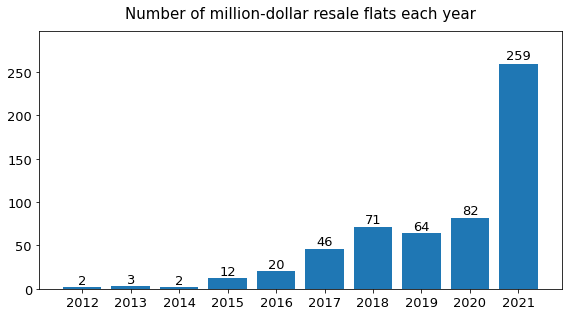

In [21]:
num_mdfs(None,multiple=50)
title = 'Number of million-dollar resale flats each year'
plt.title(title,fontsize=15,pad=13)
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600)

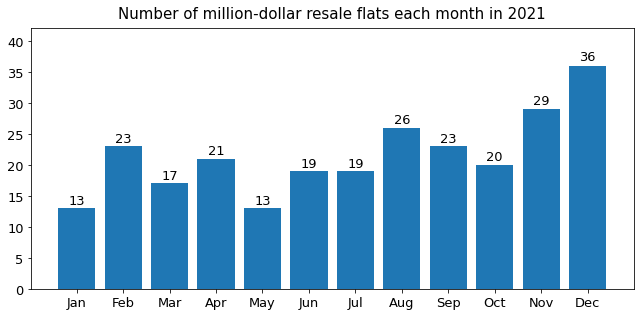

In [22]:
temp = ft_mdf.filt([('2021-01','2021-12')])
temp = temp.groupby(temp['month'].dt.month).size()

fig,ax = plt.subplots(figsize=(9,4.5))
bars = ax.bar(temp.index,temp.values)

ax.set_ylim(0,42)
ax.xaxis.set_major_locator(mticks.MultipleLocator(1))
ax.set_xticklabels([None,'Jan','Feb','Mar','Apr',
                   'May','Jun','Jul','Aug',
                   'Sep','Oct','Nov','Dec'])
ax.tick_params(axis='both',labelsize=13)
autolabel_v(bars,ax)

title = 'Number of million-dollar resale flats each month in 2021'
ax.set_title(title,fontsize=15,pad=10)
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600)

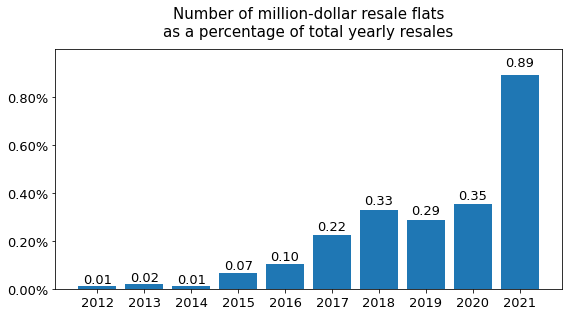

In [23]:
num_mdfs(None,perc=True,denom=None)
title = 'Number of million-dollar resale flats as a percentage of total yearly resales'
titlewrap = 'Number of million-dollar resale flats\nas a percentage of total yearly resales'
plt.title(titlewrap,fontsize=15,pad=13)
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600)

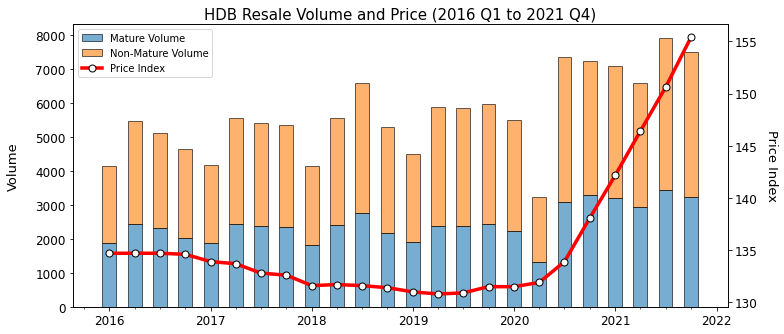

In [24]:
temp = ft.filt([('2016-01','2021-12')])
bardata = temp.groupby([temp['month'].dt.to_period('Q'),'maturity']).size().unstack()
linedata = price_index[price_index.index.year>=2016]

fig,ax = plt.subplots(figsize=(11,4.5))
ax2 = ax.twinx()

b1 = ax.bar(bardata.index.to_timestamp(),bardata['mature'],
            width=50,edgecolor='black',alpha=0.6,label='Mature Volume')

b2 = ax.bar(bardata.index.to_timestamp(),bardata['non-mature'],bottom=bardata['mature'],
            width=50,edgecolor='black',alpha=0.6,label='Non-Mature Volume')

ax.set_yticks(np.arange(0,8001,1000))
ax.tick_params(axis='y',labelsize=12)
ax.tick_params(axis='x',labelsize=12)
ax.set_ylabel('Volume',labelpad=15,fontsize=13)

l1 = ax2.plot(linedata.index.to_timestamp(),linedata.values,
              color='red',marker='o',linewidth=3.5,mfc='white',
              mec='black',markersize=7,label='Price Index')

ax2.set_yticks(np.arange(130,156,5))
ax2.tick_params(axis='y',labelsize=12)
ax2.set_ylabel('Price Index',rotation=-90,labelpad=20,fontsize=13)

ax.xaxis.set_minor_locator(mdates.MonthLocator((1,4,7,10)))

bar,barlabels = ax.get_legend_handles_labels()
line,linelabels =ax2.get_legend_handles_labels()

ax2.legend(bar+line,barlabels+linelabels,loc='upper left')

plt.tight_layout()

title = 'HDB Resale Volume and Price (2016 Q1 to 2021 Q4)'
plt.title(title,fontsize=15)
plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600,bbox_inches='tight')

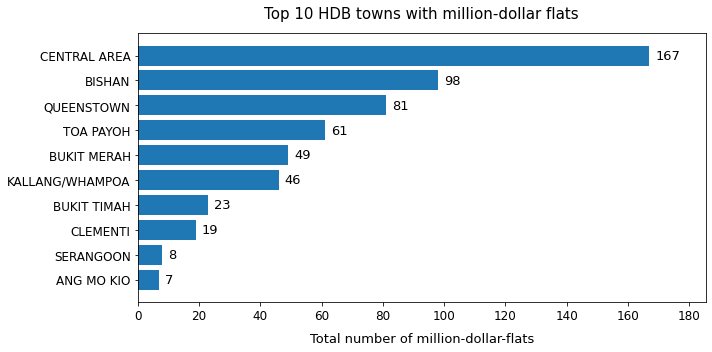

In [25]:
fig,ax = plt.subplots(figsize=(10,5))

multiple = 20

bar = mdf.groupby('town').size().sort_values().tail(10)
bar = ax.barh(bar.index,bar.values,color=tab10(0))
ax.set_xlabel('Total number of million-dollar-flats',fontsize=13,labelpad=10)
ax.set_xlim(0,ax.get_xlim()[1]+multiple/2)
ax.xaxis.set_major_locator(mticks.MultipleLocator(multiple))
ax.tick_params(axis='y',labelsize=12)
ax.tick_params(axis='x',labelsize=12)
autolabel_h(bar,ax,multiple)

title = 'Top 10 HDB towns with million-dollar flats' 
ax.set_title(title,fontsize=15,pad=15)

plt.tight_layout()
plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600,bbox_inches='tight')

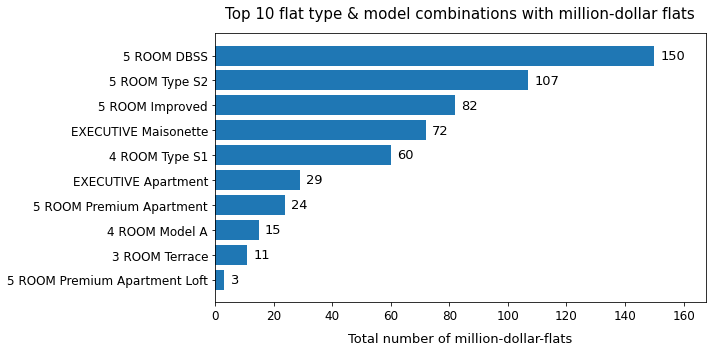

In [26]:
fig,ax = plt.subplots(figsize=(10,5))

multiple = 20

bar = mdf.groupby(['flat_type','flat_model']).size().sort_values().tail(10)
bar = ax.barh([' '.join(tup) for tup in bar.index],bar.values,color=tab10(0))
ax.set_xlabel('Total number of million-dollar-flats',fontsize=13,labelpad=10)
ax.set_xlim(0,ax.get_xlim()[1]+multiple/2)
ax.xaxis.set_major_locator(mticks.MultipleLocator(multiple))
ax.tick_params(axis='y',labelsize=12)
ax.tick_params(axis='x',labelsize=12)
autolabel_h(bar,ax,multiple)

title = 'Top 10 flat type & model combinations with million-dollar flats' 
ax.set_title(title,fontsize=15,pad=15)

plt.tight_layout()
plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600,bbox_inches='tight')

In [27]:
pinnacle = ft_mdf.filt(['THE PINNACLE@DUXTON'])
dbss = ft_mdf.filt(['DBSS'])

sers = ft_mdf.filt([['D03','D05','D10'],'not EXECUTIVE'])
#Note that only Clementi Ridges was a SERS site
not_sers = ['TRIVELIS','3 HOLLAND CL','126 BT MERAH VIEW','83 STRATHMORE AVE','43 MOH GUAN TER']
sers = sers[~sers['building'].isin(not_sers)]

executive = ft_mdf.filt(['EXECUTIVE'])
terrace = ft_mdf.filt(['Terrace'])

others = mdf.copy()

names = ['The Pinnacle@Duxton','DBSS Projects','SERS Replacement Sites','Executive Flats','Terrace Flats']

temp = []
for sub,name in zip([pinnacle,dbss,sers,executive,terrace],names):
    others = others[~others.index.isin(sub.index)]
    temp.extend([name]*len(sub))

temp.extend(['Others']*len(others))
temp = pd.Series(temp)

names.append('Others')

temp = temp.value_counts().reindex(names)

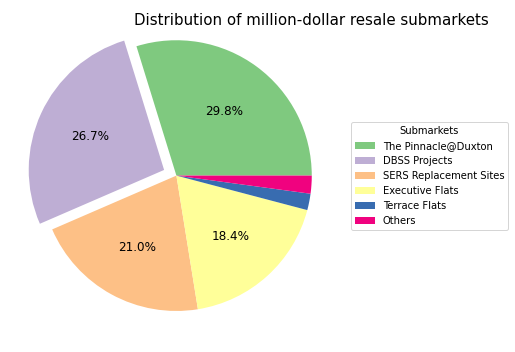

In [28]:
fig, ax = plt.subplots(figsize=(10,5), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(temp.values, autopct=lambda pct: '' if pct<10 else "{:.1f}%".format(pct),
                                  textprops=dict(color="k"),colors=accent(np.arange(6)),
                                 explode = [0,0.1,0,0,0,0],shadow=False)

ax.legend(wedges, temp.index,
          title="Submarkets",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12)

title = 'Distribution of million-dollar resale submarkets'
ax.set_title(title,fontsize=15,x=0.9,y=0.93)
plt.tight_layout()

plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600,bbox_inches='tight')

### The Pinnacle@Duxton

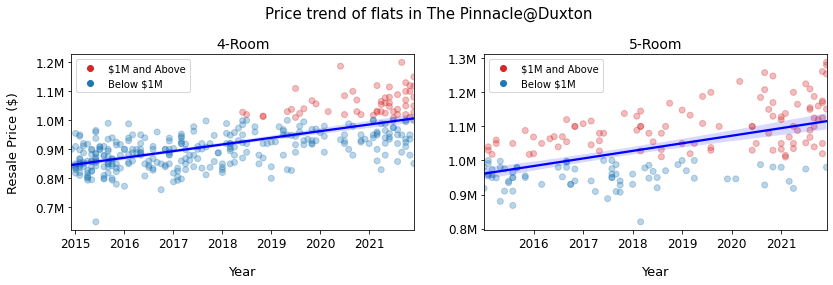

In [29]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
price_regplot(['THE PINNACLE@DUXTON','4 ROOM'],ax=ax[0])
ax[0].set_title('4-Room',fontsize=14)
price_regplot(['THE PINNACLE@DUXTON','5 ROOM'],ax=ax[1])
ax[1].set_title('5-Room',fontsize=14)
ax[1].set_ylabel('')

suptitle = 'Price trend of flats in The Pinnacle@Duxton'
plt.suptitle(suptitle,fontsize=15)
fig.subplots_adjust(top=0.8,wspace=5)
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{suptitle}.jpg',dpi=600,bbox_inches='tight')

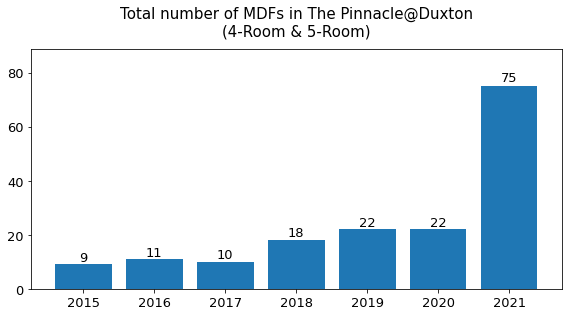

In [30]:
num_mdfs(['THE PINNACLE@DUXTON'],multiple=20)
titlewrap = 'Total number of MDFs in The Pinnacle@Duxton\n(4-Room & 5-Room)'
title = 'Total number of MDFs in The Pinnacle@Duxton'
plt.title(titlewrap,pad=13,fontsize=15)
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600,bbox_inches='tight')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


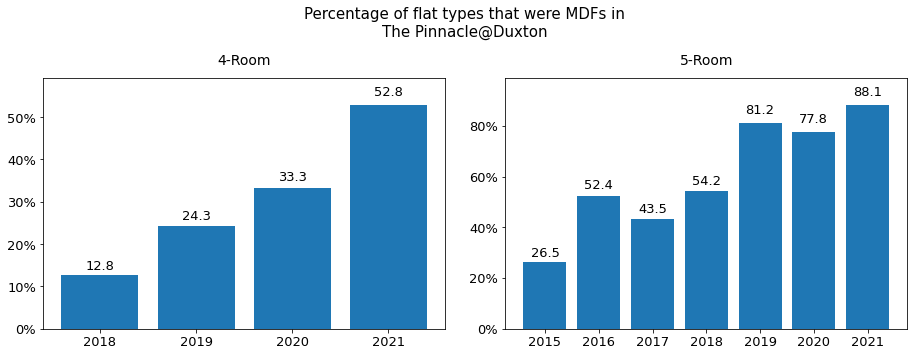

In [31]:
fig,ax = plt.subplots(1,2,figsize=(13,5))

num_mdfs(['THE PINNACLE@DUXTON','4 ROOM'],perc=True,ax=ax[0]) 
ax[0].set_title('4-Room',pad=13,fontsize=14)

num_mdfs(['THE PINNACLE@DUXTON','5 ROOM'],perc=True,ax=ax[1]) 
ax[1].set_title('5-Room',pad=13,fontsize=14)

suptitle = 'Percentage of flat types that were MDFs in\nThe Pinnacle@Duxton'
savetitle = 'Percentage of flat types that were MDFs in The Pinnacle@Duxton'
plt.suptitle(suptitle,fontsize=15)
fig.subplots_adjust(top=0.8,wspace=30)
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{savetitle}.jpg',dpi=600,bbox_inches='tight')

### DBSS

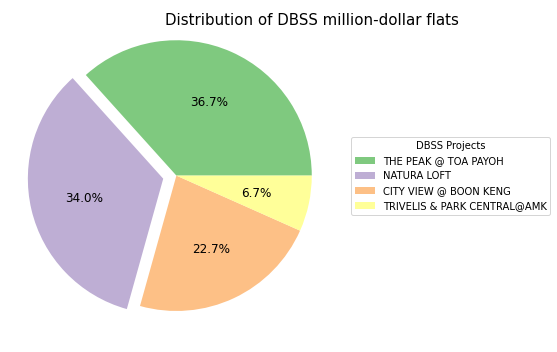

In [32]:
temp = ft_mdf.filt(['DBSS'])['building'].value_counts()
temp['TRIVELIS & PARK CENTRAL@AMK'] = temp[-2:].sum()
temp = temp.drop(['TRIVELIS','PARK CENTRAL @ AMK'])

cmap = plt.get_cmap('Accent')

fig, ax = plt.subplots(figsize=(10,5), subplot_kw=dict(aspect="equal"))


wedges, texts, autotexts = ax.pie(temp.values, autopct='%1.1f%%',
                                  textprops=dict(color="k"),colors=cmap(np.arange(5)),
                                 explode=[0,0.1,0,0])

ax.legend(wedges, temp.index,
          title="DBSS Projects",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12)

title = 'Distribution of DBSS million-dollar flats'
ax.set_title(title,fontsize=15,x=0.9,y=0.93)
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600,bbox_inches='tight')

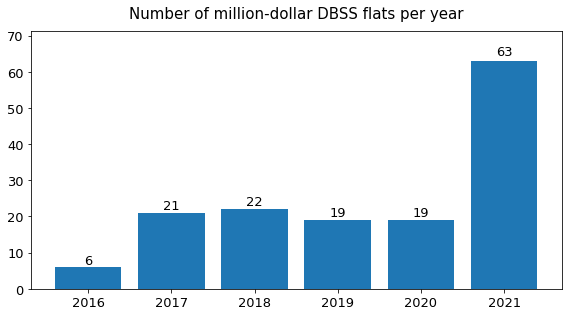

In [33]:
num_mdfs(['DBSS'],multiple=10)
title = 'Number of million-dollar DBSS flats per year'
plt.title(title,pad=13,fontsize=15)
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600,bbox_inches='tight')

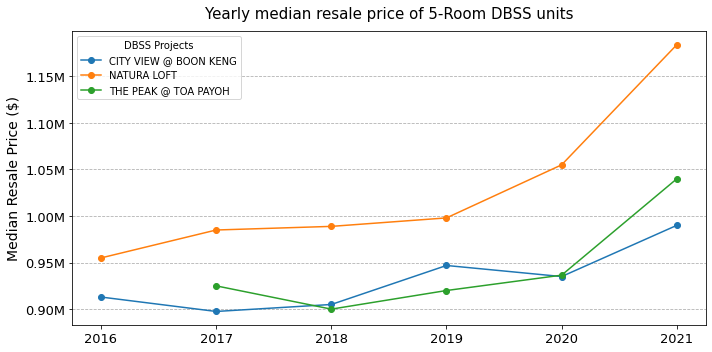

In [34]:
fig,ax = plt.subplots(figsize=(10,5))

temp = ft.filt([['THE PEAK @ TOA PAYOH','NATURA LOFT','CITY VIEW @ BOON KENG'],'5 ROOM'])
medplot = temp.groupby([temp['month'].dt.year,'building']).median()['resale_price'].unstack()

medplot.plot(ax=ax,marker='o',markersize=6)
ax.yaxis.set_major_formatter(millions_2dp)
ax.tick_params(axis='both',labelsize=13)
ax.set_ylabel('Median Resale Price ($)',fontsize=14)
ax.set_xlabel('')

title = 'Yearly median resale price of 5-Room DBSS units'
ax.set_title(title,fontsize=15,pad=13)
ax.legend(title='DBSS Projects')
ax.grid(axis='y',linestyle='--')
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600,bbox_inches='tight')

Text(0.5, 0.98, 'The Peak@Toa Payoh')

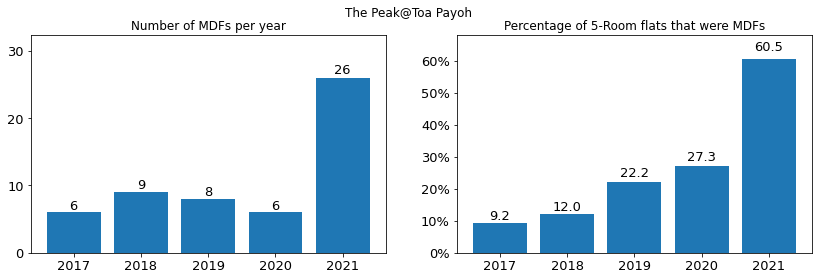

In [35]:
fig,ax = plt.subplots(1,2,figsize=(14,4))
num_mdfs(['THE PEAK @ TOA PAYOH'],ax=ax[0])
ax[0].set_title('Number of MDFs per year')
num_mdfs(['THE PEAK @ TOA PAYOH'],perc=True,denom=['THE PEAK @ TOA PAYOH','5 ROOM'],ax=ax[1])
ax[1].set_title('Percentage of 5-Room flats that were MDFs')
plt.suptitle('The Peak@Toa Payoh')

Text(0.5, 0.98, 'Natura Loft')

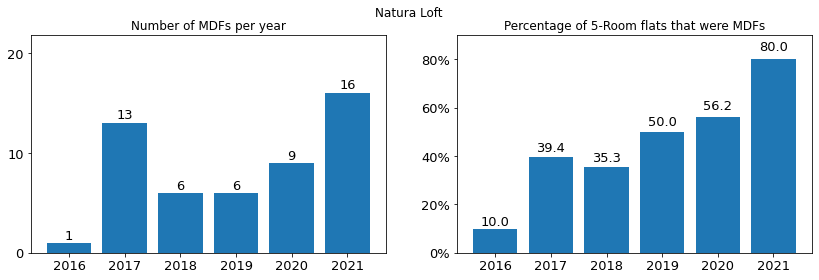

In [36]:
fig,ax = plt.subplots(1,2,figsize=(14,4))
num_mdfs(['NATURA LOFT'],ax=ax[0])
ax[0].set_title('Number of MDFs per year')
num_mdfs(['NATURA LOFT'],perc=True,denom=['NATURA LOFT','5 ROOM'],ax=ax[1])
ax[1].set_title('Percentage of 5-Room flats that were MDFs')
plt.suptitle('Natura Loft')

Text(0.5, 0.98, 'City View@Boon Keng')

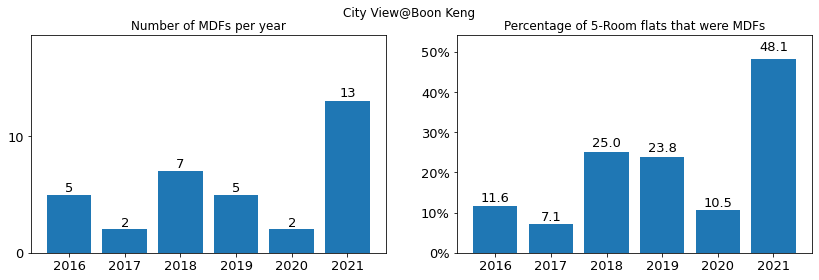

In [37]:
fig,ax = plt.subplots(1,2,figsize=(14,4))
num_mdfs(['CITY VIEW @ BOON KENG'],ax=ax[0])
ax[0].set_title('Number of MDFs per year')
num_mdfs(['CITY VIEW @ BOON KENG'],perc=True,denom=['CITY VIEW @ BOON KENG','5 ROOM'],ax=ax[1])
ax[1].set_title('Percentage of 5-Room flats that were MDFs')
plt.suptitle('City View@Boon Keng')

Text(0.5, 1.0, 'Price trend of 5-Room flats in Natura Loft')

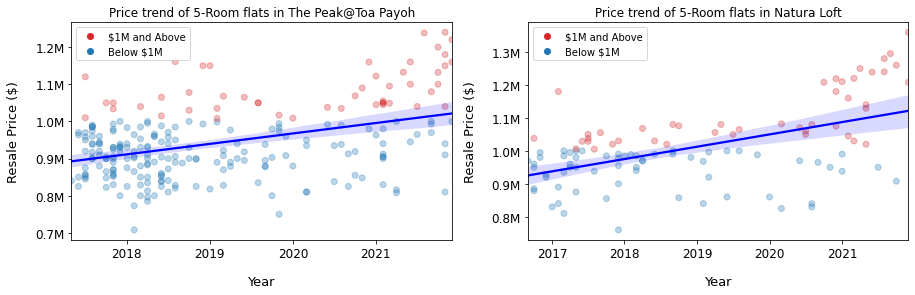

In [38]:
fig,ax = plt.subplots(1,2,figsize=(15,4))

price_regplot(['THE PEAK @ TOA PAYOH','5 ROOM'],ax=ax[0])
ax[0].set_title('Price trend of 5-Room flats in The Peak@Toa Payoh')
          
price_regplot(['NATURA LOFT','5 ROOM'],ax=ax[1])
ax[1].set_title('Price trend of 5-Room flats in Natura Loft')

Text(0.5, 1.0, 'Price trend of 5-Room flats in City View@Boon Keng')

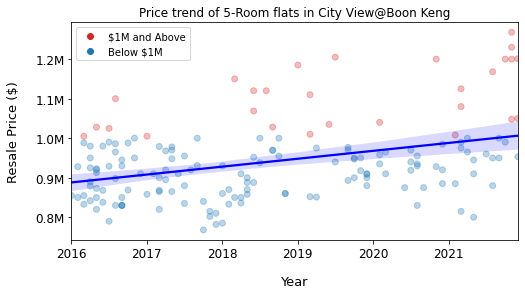

In [39]:
price_regplot(['CITY VIEW @ BOON KENG','5 ROOM'])
plt.title('Price trend of 5-Room flats in City View@Boon Keng')

### New SERS Replacement Sites in District 3, 5 and 10

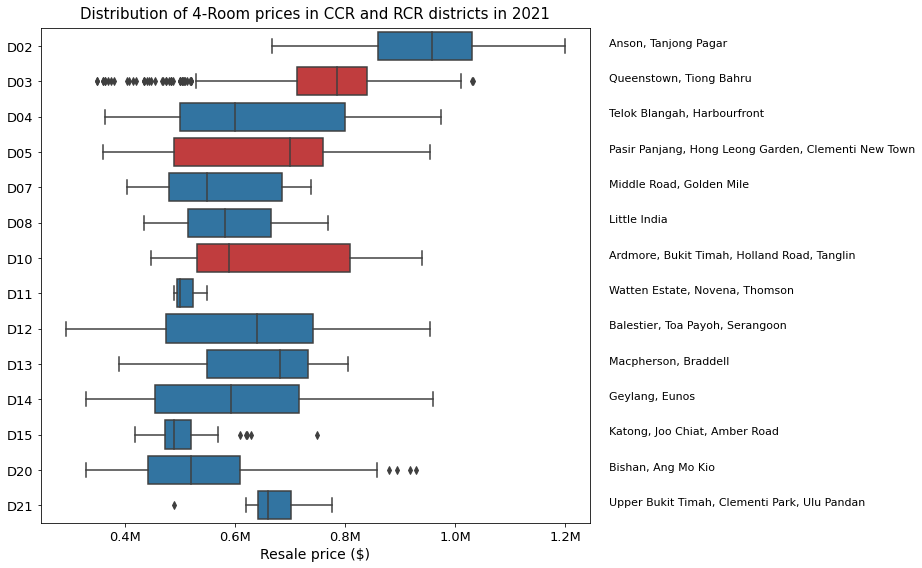

In [40]:
fig,ax = plt.subplots(figsize=(13,8))
temp = ft.filt([['CCR','RCR'],('2021-01','2021-12'),'4 ROOM','not D01'])

districts = list(map(str,sorted(temp['district'].unique())))
palette = {district: tab10(3) if district in ['3','5','10'] else tab10(0) for district in districts}
labels = ['D'+district.zfill(2) for district in districts]

sns.boxplot(x='resale_price',y=temp['district'].astype(str),data=temp,
            order=districts,
           palette=palette,ax=ax)

ax.set_ylabel('')
ax.set_xlabel('Resale price ($)',fontsize=14)
ax.set_yticklabels(labels)
ax.xaxis.set_major_formatter(millions)

ax.tick_params(axis='both',labelsize=13)

title = 'Distribution of 4-Room prices in CCR and RCR districts in 2021'
ax.set_title(title,fontsize=15,pad=10)

for pos,district in zip(range(len(districts)),list(map(int,districts))):
    ax.text(1.28e6,pos,postal.loc[district]['General Location'].replace('  ',' '),ha='left',fontsize=11)

plt.tight_layout()

plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600,bbox_inches='tight')

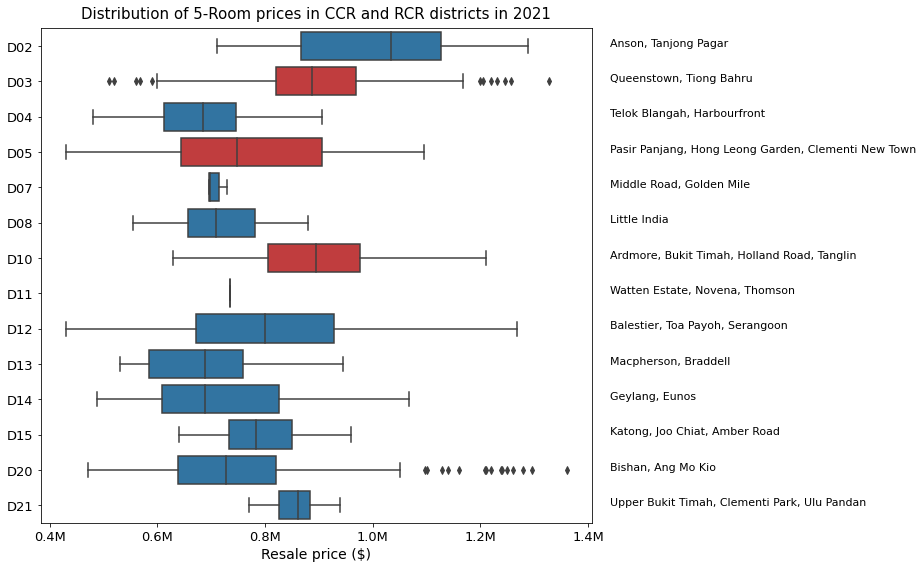

In [41]:
fig,ax = plt.subplots(figsize=(13,8))
temp = ft.filt([['CCR','RCR'],('2021-01','2021-12'),'5 ROOM'])

districts = list(map(str,sorted(temp['district'].unique())))
palette = {district: tab10(3) if district in ['3','5','10'] else tab10(0) for district in districts}
labels = ['D'+district.zfill(2) for district in districts]

sns.boxplot(x='resale_price',y=temp['district'].astype(str),data=temp,
            order=districts,
           palette=palette,ax=ax)

ax.set_ylabel('')
ax.set_xlabel('Resale price ($)',fontsize=14)
ax.set_yticklabels(labels)
ax.xaxis.set_major_formatter(millions)

ax.tick_params(axis='both',labelsize=13)

title = 'Distribution of 5-Room prices in CCR and RCR districts in 2021'
ax.set_title(title,fontsize=15,pad=10)

for pos,district in zip(range(len(districts)),list(map(int,districts))):
    ax.text(1.44e6,pos,postal.loc[district]['General Location'].replace('  ',' '),ha='left',fontsize=11)

plt.tight_layout()

plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600,bbox_inches='tight')

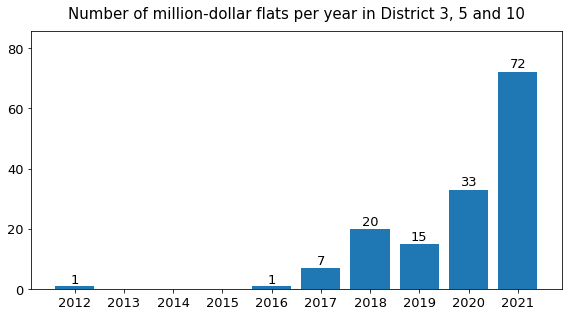

In [42]:
num_mdfs([['D3','D5','D10']],multiple=20)
title = 'Number of million-dollar flats per year in District 3, 5 and 10'
plt.title(title,pad=13,fontsize=15)
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600,bbox_inches='tight')

In [43]:
temp = ft.filt(['4 ROOM',('2021-01','2021-12')]).groupby('building').agg([np.median,np.size])['resale_price']
highlighted = ['TIONG BAHRU VIEW','CITY VUE @HENDERSON','BUONA VISTA COURT',
               'SKYTERRACE @ DAWSON','CLEMENTI RIDGES','HAVELOCK VIEW','BOON TIONG ARCADIA']

temp[temp['size']>=10].sort_values('median',ascending=False).head(10).rename(columns={'median':'Median Resale Price',
                                                                                      'size':'Number of units sold in 2021'})\
.style.apply(lambda x: ['background-color:lightgreen' if x.name in highlighted else '' for i in x],axis=1)\
.format({'Median Resale Price':'${:,.0f}'})\
.set_properties(subset=['Median Resale Price','Number of units sold in 2021'], **{'width': '85px'})

,Median Resale Price,Number of units sold in 2021
building,,
THE PINNACLE@DUXTON,"$1,000,000",72
TIONG BAHRU VIEW,"$935,000",31
CITY VUE @HENDERSON,"$910,000",15
BUONA VISTA COURT,"$880,500",12
KALLANG TRIVISTA,"$866,500",20
SKYTERRACE @ DAWSON,"$859,000",78
THE PEAK @ TOA PAYOH,"$853,088",25
CLEMENTI RIDGES,"$843,000",31
HAVELOCK VIEW,"$843,000",12


### Executive Flats

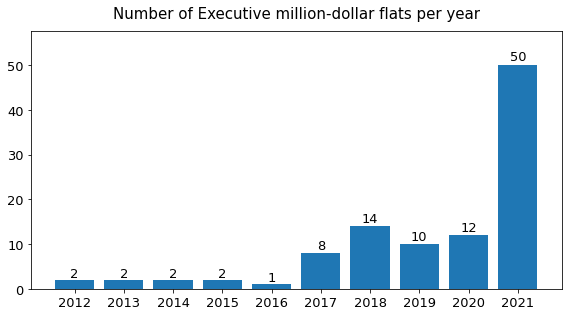

In [44]:
num_mdfs(['EXECUTIVE'],multiple=10)
title = 'Number of Executive million-dollar flats per year'
plt.title(title,pad=13,fontsize=15)
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600,bbox_inches='tight')

#### Bishan

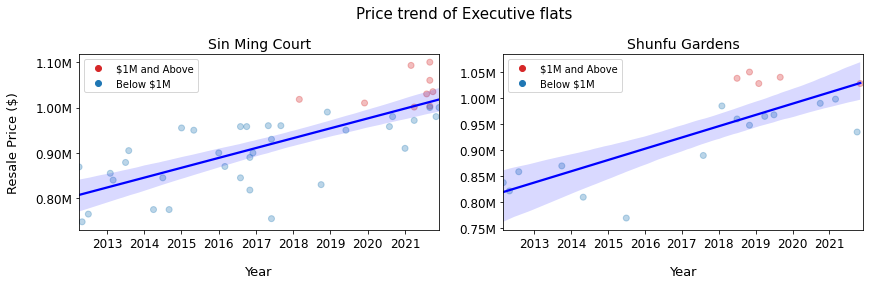

In [45]:
fig,ax = plt.subplots(1,2,figsize=(13,4))
price_regplot(['SIN MING COURT','EXECUTIVE'],ax=ax[0],formatter=millions_2dp)
ax[0].set_title('Sin Ming Court',fontsize=14)

price_regplot(['SHUNFU GARDENS','EXECUTIVE'],ax=ax[1],formatter=millions_2dp)
ax[1].set_title('Shunfu Gardens',fontsize=14)
ax[1].set_ylabel('')

suptitle = 'Price trend of Executive flats'
plt.suptitle(suptitle,fontsize=15)
fig.subplots_adjust(top=0.8,wspace=10)
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{suptitle}.jpg',dpi=600,bbox_inches='tight')

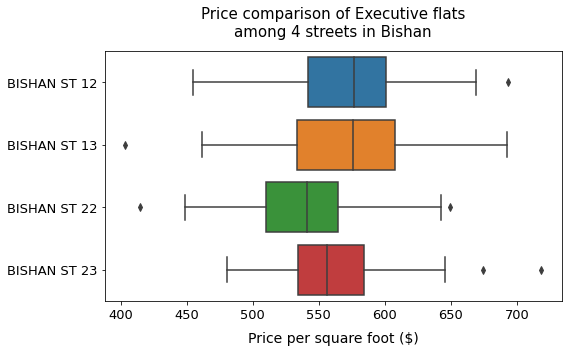

In [46]:
fig,ax = plt.subplots(figsize=(8,5))
streets = ['BISHAN ST 12','BISHAN ST 13','BISHAN ST 22','BISHAN ST 23']
temp = ft.filt([streets,'EXECUTIVE'])

sns.boxplot(x='psf',y='street',data=temp,order=streets,ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Price per square foot ($)',fontsize=14,labelpad=10)
ax.tick_params(axis='both',labelsize=13)

title = 'Price comparison of Executive flats\namong 4 streets in Bishan'
savetitle = 'Price comparison of Executive flats among 4 streets in Bishan'
ax.set_title(title,fontsize=15,pad=15)
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{savetitle}.jpg',dpi=600,bbox_inches='tight')

In [47]:
temp = ft_mdf.filt([streets,'EXECUTIVE'])

pd.crosstab(temp['street'],temp['storey_range'])\
.style.applymap(lambda x: 'background-color:black' if x==0 else '')

storey_range,01 TO 03,04 TO 06,07 TO 09,10 TO 12,13 TO 15,16 TO 18,19 TO 21,22 TO 24
street,,,,,,,,
BISHAN ST 12,1,0,0,0,0,0,0,4
BISHAN ST 13,0,1,1,3,0,0,8,5
BISHAN ST 22,0,1,1,1,1,0,0,0
BISHAN ST 23,0,1,1,0,1,1,0,0


#### Toh Yi Gardens

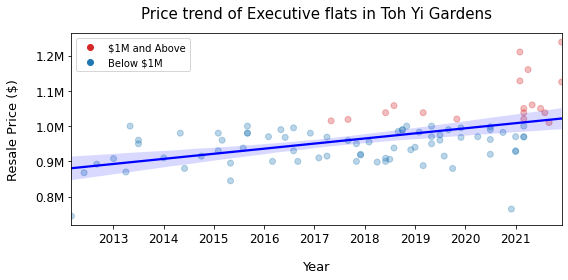

In [48]:
price_regplot(['TOH YI GARDENS','EXECUTIVE'])
title = 'Price trend of Executive flats in Toh Yi Gardens'
plt.title(title,fontsize=15,pad=15)
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600,bbox_inches='tight')

#### Mei Ling St

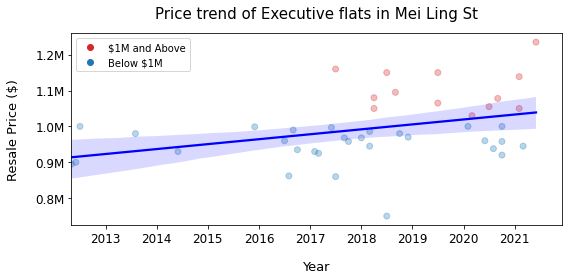

In [49]:
price_regplot(['MEI LING ST','EXECUTIVE'])
title = 'Price trend of Executive flats in Mei Ling St'
plt.title(title,fontsize=15,pad=15)
plt.tight_layout()
plt.savefig(f'Plots/MDFs/{title}.jpg',dpi=600,bbox_inches='tight')

### Whampoa HDB Terrace Estate

In [50]:
temp = ft.filt(['Terrace']).loc[:,['floor_area_sqft','town','remaining_lease','psf']]
temp = pd.get_dummies(temp).rename(columns={'town_KALLANG/WHAMPOA':'whampoa',
                                           'town_QUEENSTOWN':'queenstown'})

model = smf.ols('psf ~ whampoa + queenstown + remaining_lease + floor_area_sqft + I(floor_area_sqft**-1)',data=temp).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    psf   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     190.0
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           7.04e-52
Time:                        13:44:04   Log-Likelihood:                -697.34
No. Observations:                 129   AIC:                             1405.
Df Residuals:                     124   BIC:                             1419.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  372.6639     78.234      4.763      0.000     217.816     527.511
whampoa                    173.2569     41.794      4.146      0.000      90.536     255.978
queenstown                 199.4070     37.347      5.339      0.000     125.488     273.326
remaining_lease             -2.8713      1.680     -1.710      0.090      -6.196       0.453
floor_area_sqft             -0.0564      0.030     -1.896      0.060      -0.115       0.002
I(floor_area_sqft ** -1)  4.442e+05   6.28e+04      7.069      0.000     3.2e+05    5.69e+05
==============================================================================
Omnibus:                        2.252   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.324   Jarque-Bera (JB):                1.838
Skew:                          -0.282   Prob(JB):                        0.399
Kurtosis:                       3.157   Cond. No.                     2.82e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.88e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [51]:
temp = ft.filt(['Terrace']).loc[:,['floor_area_sqft','psf']]

model = smf.ols('psf ~ floor_area_sqft + I(floor_area_sqft**-1)',data=temp).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    psf   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     346.3
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           6.28e-52
Time:                        13:44:05   Log-Likelihood:                -703.32
No. Observations:                 129   AIC:                             1413.
Df Residuals:                     126   BIC:                             1421.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  467.5885     93.430      5.005      0.000     282.693     652.484
floor_area_sqft             -0.0802      0.030     -2.664      0.009      -0.140      -0.021
I(floor_area_sqft ** -1)  4.015e+05   6.39e+04      6.282      0.000    2.75e+05    5.28e+05
==============================================================================
Omnibus:                        1.298   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.523   Jarque-Bera (JB):                0.919
Skew:                          -0.188   Prob(JB):                        0.632
Kurtosis:                       3.172   Cond. No.                     1.69e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

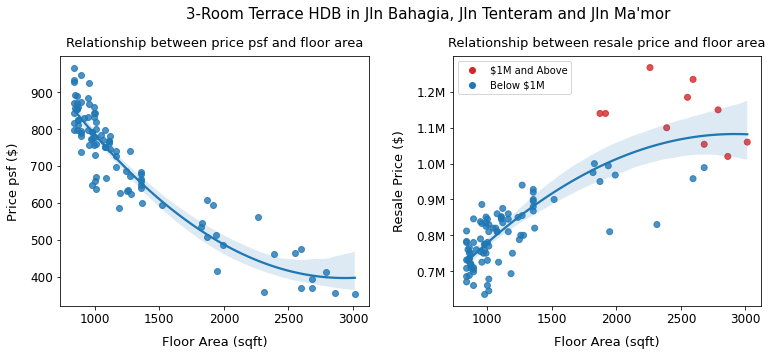

In [52]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

#Relationship between price psf and floor area
sns.regplot(x='floor_area_sqft',y='psf',
            data=ft.filt(['KALLANG/WHAMPOA','Terrace']),order=2,ax=ax[0])

ax[0].set_ylabel('Price psf ($)',fontsize=13,labelpad=10)
ax[0].set_title('Relationship between price psf and floor area',fontsize=13,pad=10)

#Relationship between resale price and floor area
red = rgb2hex(tab10(3))
blue= rgb2hex(tab10(0))
    
colors = np.where(ft.filt(['KALLANG/WHAMPOA','Terrace'])['resale_price']>1e6,red,blue).tolist()

sns.regplot(x='floor_area_sqft',y='resale_price',
            data=ft.filt(['KALLANG/WHAMPOA','Terrace']),order=2,ax=ax[1],
           scatter_kws={'color':colors})

ax[1].yaxis.set_major_formatter(millions)
ax[1].set_ylabel('Resale Price ($)',fontsize=13,labelpad=10)
ax[1].set_title('Relationship between resale price and floor area',fontsize=13,pad=10)

leg_colors = [red,blue]
leg_markers = ['o','o']
leg_labels = ['$1M and Above','Below $1M']
    
ax[1].legend(list(zip(leg_colors,leg_markers)),
             leg_labels,handler_map={tuple:MarkerHandler()}) 

for n in range(2):
    ax[n].set_xlabel('Floor Area (sqft)',fontsize=13,labelpad=10)
    ax[n].tick_params(axis='both',labelsize=12)
    
fig.subplots_adjust(wspace=20)
suptitle = "3-Room Terrace HDB in Jln Bahagia, Jln Tenteram and Jln Ma'mor"
plt.suptitle(suptitle,fontsize=15)
plt.tight_layout()

plt.savefig(f'Plots/MDFs/{suptitle}.jpg',dpi=600,bbox_inches='tight')